<a href="https://colab.research.google.com/github/cody628/git_test11/blob/main/AI_crime_prevention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
### kagle 사이트에서 dataset 받아오기
# install
!pip install kaggle --upgrade

In [2]:
# 저장된 kaggle.json 파일을 colb에 upload
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"seokjunhwang","key":"a007ef7fb89282433b2b741d89829e92"}'}

In [3]:
# kaggle.json 파일의 위치 변경
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
# 잘 저장되었는지 확인
!ls -1ha kaggle.json

kaggle.json


In [5]:
# 필요한 데이터셋 불러오기
!kaggle datasets download -d ankan1998/weapon-detection-dataset

 99% 481M/487M [00:06<00:00, 80.6MB/s]
100% 487M/487M [00:06<00:00, 82.1MB/s]


In [6]:
# 잘 저장되었는지 확인 후 unzip
!ls
!unzip weapon-detection-dataset.zip

kaggle.json  sample_data  weapon-detection-dataset.zip
Archive:  weapon-detection-dataset.zip
  inflating: Sohas_weapon-Detection/annotations/trainval.txt  
  inflating: Sohas_weapon-Detection/annotations/xmls/ABbframe00154.xml  
  inflating: Sohas_weapon-Detection/annotations/xmls/ABbframe00160.xml  
  inflating: Sohas_weapon-Detection/annotations/xmls/ABbframe00166.xml  
  inflating: Sohas_weapon-Detection/annotations/xmls/ABbframe00169.xml  
  inflating: Sohas_weapon-Detection/annotations/xmls/ABbframe00190.xml  
  inflating: Sohas_weapon-Detection/annotations/xmls/ABbframe00235.xml  
  inflating: Sohas_weapon-Detection/annotations/xmls/ABbframe00265.xml  
  inflating: Sohas_weapon-Detection/annotations/xmls/ABbframe00271.xml  
  inflating: Sohas_weapon-Detection/annotations/xmls/ABbframe00274.xml  
  inflating: Sohas_weapon-Detection/annotations/xmls/ABbframe00277.xml  
  inflating: Sohas_weapon-Detection/annotations/xmls/ABbframe00280.xml  
  inflating: Sohas_weapon-Detection/anno

In [12]:
### 주언진 이미지에 바운딩 박스를 시각화해 올바르게 레이블링된 데이터인지 확인
# 바운딩 박스 시각화 코드를 테스트하기 위해 필요한 패키지 불러옴
import os
import glob # 파일을 다루는 패키지
import matplotlib.pyplot as plt # 시각화 패키지
import matplotlib.image as mpimg
import matplotlib.patches as patches
from bs4 import BeautifulSoup # xml 문서 파일을 파싱하는 패키지

# glob 패키지를 이용해 dataset 불러오기
img_list = sorted(glob.glob('/content/Sohas_weapon-Detection/images/*'))
annot_list = sorted(glob.glob('/content/Sohas_weapon-Detection/annotations/xmls/*'))

# 각 폴더에 들어있는 파일 갯수 파악, 확인
print('img_list 갯수 : ', len(img_list))
print('annot_list 갯수 : ', len(annot_list))

# 각각의 폴더에 들어있는 파일이 제대로 있는지 확인 파일의 ID 순서가 동일한지 확인
print(img_list[:10])
print(annot_list[:10])

img_list 갯수 :  1000
annot_list 갯수 :  1000
['/content/Sohas_weapon-Detection/images/ABbframe00154.jpg', '/content/Sohas_weapon-Detection/images/ABbframe00160.jpg', '/content/Sohas_weapon-Detection/images/ABbframe00166.jpg', '/content/Sohas_weapon-Detection/images/ABbframe00169.jpg', '/content/Sohas_weapon-Detection/images/ABbframe00190.jpg', '/content/Sohas_weapon-Detection/images/ABbframe00235.jpg', '/content/Sohas_weapon-Detection/images/ABbframe00265.jpg', '/content/Sohas_weapon-Detection/images/ABbframe00271.jpg', '/content/Sohas_weapon-Detection/images/ABbframe00274.jpg', '/content/Sohas_weapon-Detection/images/ABbframe00277.jpg']
['/content/Sohas_weapon-Detection/annotations/xmls/ABbframe00154.xml', '/content/Sohas_weapon-Detection/annotations/xmls/ABbframe00160.xml', '/content/Sohas_weapon-Detection/annotations/xmls/ABbframe00166.xml', '/content/Sohas_weapon-Detection/annotations/xmls/ABbframe00169.xml', '/content/Sohas_weapon-Detection/annotations/xmls/ABbframe00190.xml', '/cont

In [13]:
### 바운딩 박스 시각화를 위한 함수 정의
# 바운딩 박스 좌표 값 반환
def generate_box(obj):
  xmin = float(obj.find('xmin').text)
  ymin = float(obj.find('ymin').text)
  xmax = float(obj.find('xmax').text)
  ymax = float(obj.find('ymax').text)

  return [xmin, ymin, xmax, ymax]

# 칼 바운딩 박스면 1로 칼이 아닌 바운딩 박스면 0으로 반환
def generate_label(obj):
  if obj.find('name').text == "knife":
    return 1
  return 0

# 'generate_box'와 'generate_label'를 각각 호출하여 반환된 값을 딕셔너리에 저장해 반환
def generate_target(file):
    with open(file) as f:
        data = f.read()
        soup = BeautifulSoup(data, "html.parser")
        objects = soup.find_all("object")

        num_objs = len(objects)

        boxes = []
        labels = []
        for i in objects:
            boxes.append(generate_box(i))
            labels.append(generate_label(i))

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels

        return target

# 이미지와 바운딩 박스를 함께 시각화 하는 함수(칼이면 초록색, 칼이 아니면 빨강색)
def plot_image(img_path, annotation):

    img = mpimg.imread(img_path)

    fig,ax = plt.subplots(1)
    ax.imshow(img)

    for idx in range(len(annotation["boxes"])):
        xmin, ymin, xmax, ymax = annotation["boxes"][idx]

        if annotation['labels'][idx] == 0 :
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')

        else:
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='g',facecolor='none')

        ax.add_patch(rect)

    plt.show()

In [14]:
### 이미지 바운딩이 잘 되었는지 확인
# 아무 이미지를 골라 확인하기 위해 해당 이미지 인덱스 확인
img_list.index('/content/Sohas_weapon-Detection/images/DefenseKnifeAttack0173.jpg')

114

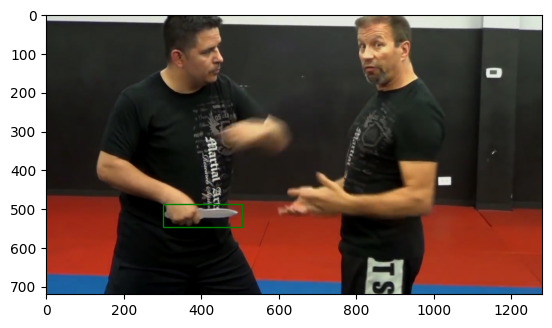

In [15]:
# bbox에 해당 이미지에서의 바운딩 박스 정보를 저장
bbox = generate_target(annot_list[114])

# 이미지 위치와 이미지에서의 바운딩 박스 정보를 주워 바운딩 박스 확인
plot_image(img_list[114], bbox)